## **Lung Cancer Histopathological Images Dataset**

This dataset contains **lung tissue images** classified into **three categories**:

- **Adenocarcinoma** – malignant tumor of glandular tissue  
- **Squamous Cell Carcinoma** – malignant tumor of squamous cells  
- **Benign** – normal, non-cancerous tissue  

Images are in **JPEG format** and organized by class. This dataset is useful for **training and evaluating machine learning models** for lung cancer classification.

You can access the dataset [here](https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images/data?select=squamous_cell_carcinoma).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/lung-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.55G/1.55G [00:13<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import  preprocess_input
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Reading & Augmenting the Dataset

In [ ]:
size = 224
train_dir = '/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1'
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,
                      batch_size=16,
                      target_size=(size,size),
                      subset="training",
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=True)

Found 13500 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}

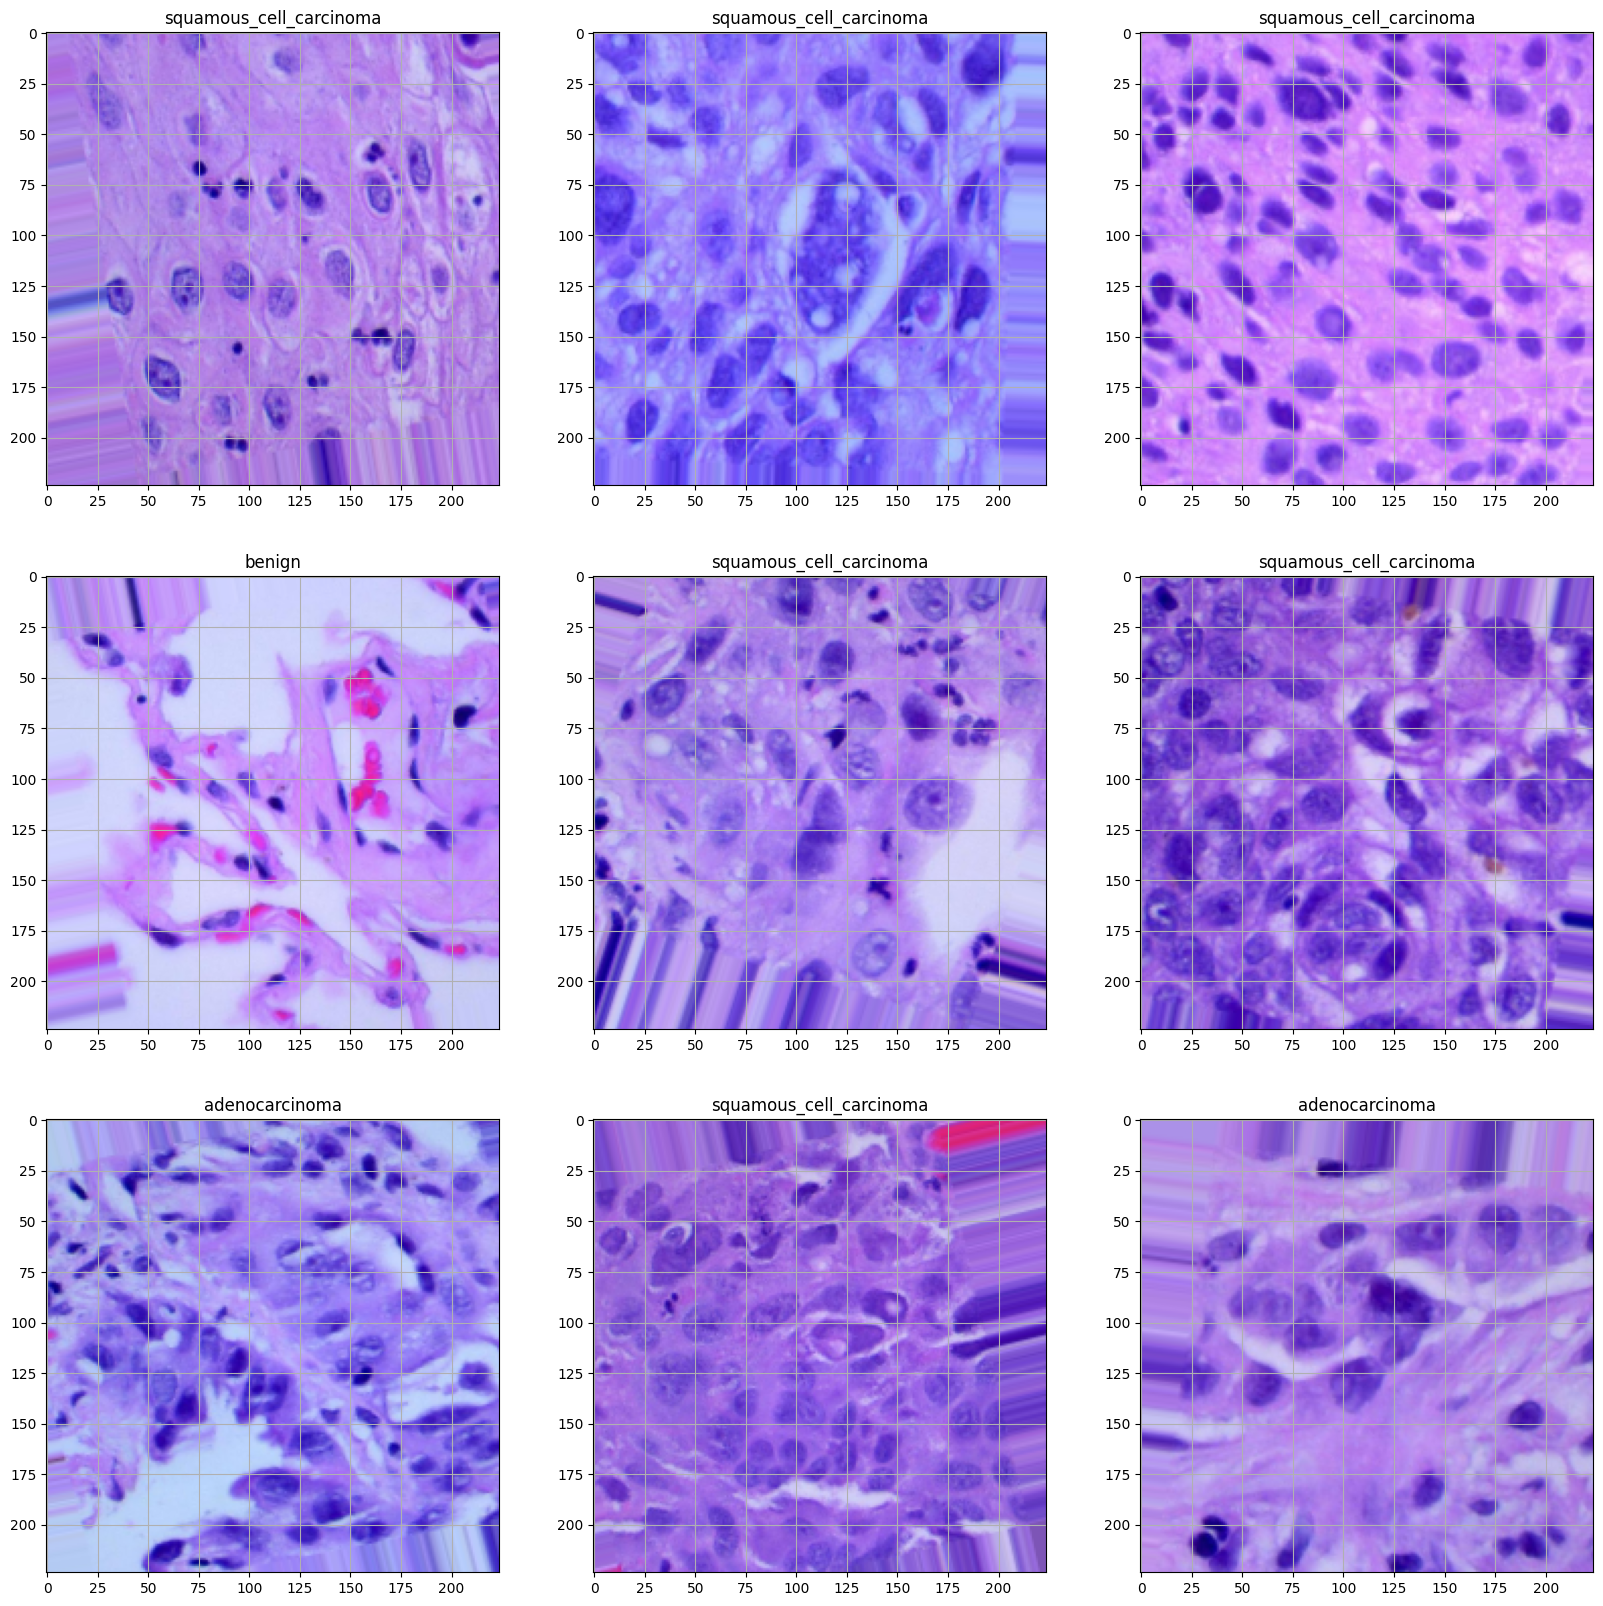

In [ ]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i],axis=-1)])
        plt.grid(None)
    plt.show()
    break

In [ ]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,
                      batch_size=16,
                      target_size=(size,size),
                      subset='validation',
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=False)

Found 1500 images belonging to 3 classes.


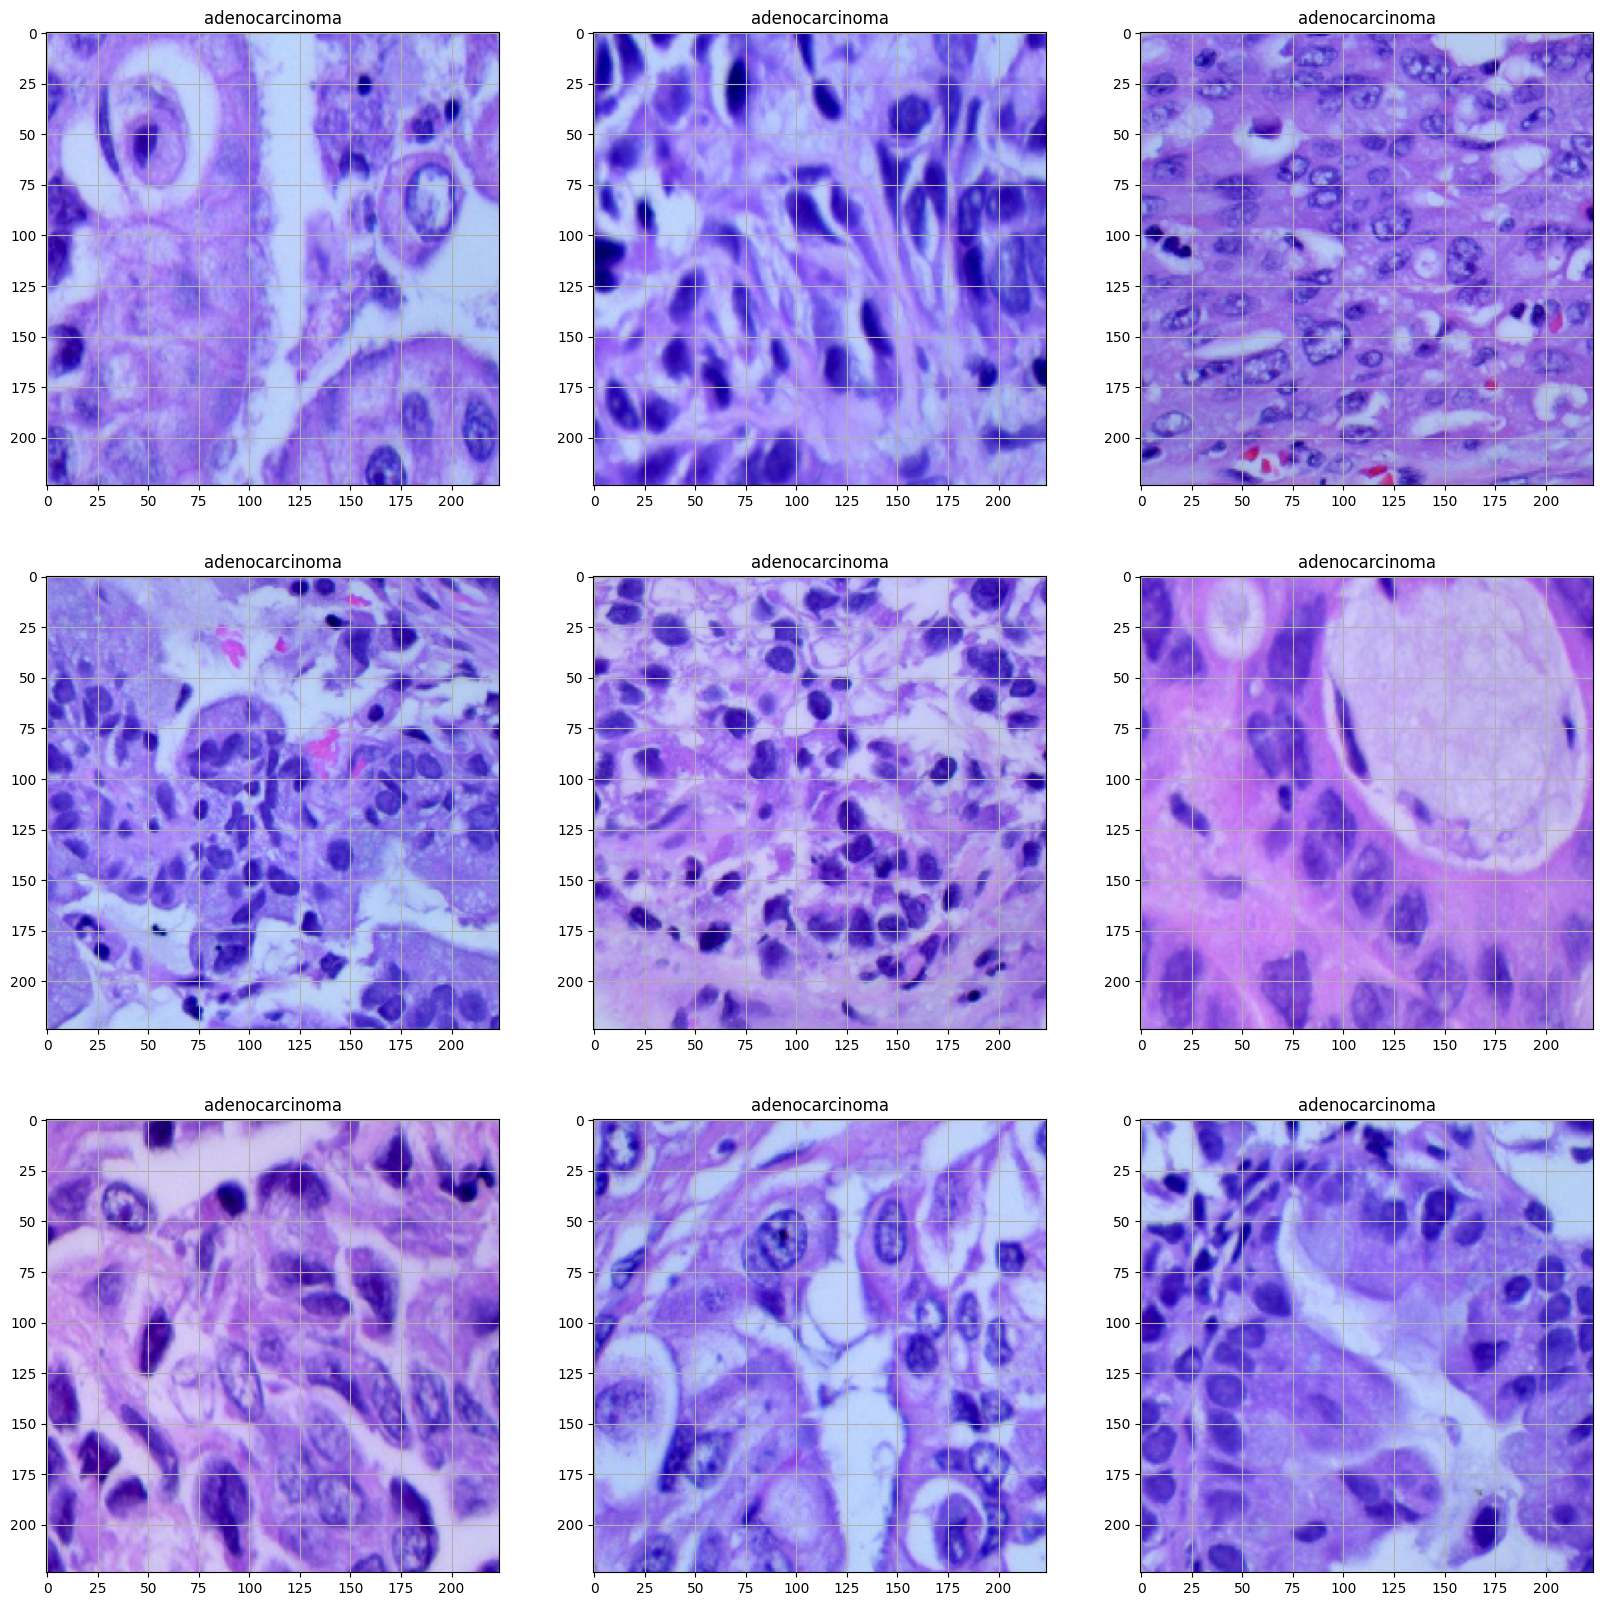

In [ ]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i],axis=-1)])
        plt.grid(None)
    plt.show()
    break

# The Model

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3,3),strides=(1,1),padding='same', activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3),strides=(1,1),padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3),strides=(1,1),padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(3,activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,067 (500.26 KB)

 Trainable params: 127,555 (498.26 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
Early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

Model_check = tf.keras.callbacks.ModelCheckpoint(
    filepath = "/content/sample_data/best_model.keras",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    cooldown=2,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
history = model.fit(train_generator,
                    batch_size= 32,
                    epochs= 30,
                    validation_data= valid_generator,
                    callbacks=[Early,Model_check,reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 240s 275ms/step - accuracy: 0.8300 - loss: 0.4081 - val_accuracy: 0.7980 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 223s 265ms/step - accuracy: 0.8744 - loss: 0.3146 - val_accuracy: 0.9267 - val_loss: 0.1898 - learning_rate: 0.0010
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 220s 261ms/step - accuracy: 0.9013 - loss: 0.2536 - val_accuracy: 0.7760 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 222s 263ms/step - accuracy: 0.8982 - loss: 0.2663 - val_accuracy: 0.8913 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 224s 266ms/step - accuracy: 0.9008 - loss: 0.2451 - val_accuracy: 0.9293 - val_loss: 0.1874 - learning_rate: 0.0010
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 227s 269ms/step - accuracy: 0.9057 - loss: 0.2333 - val_accuracy: 0.8633 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 228s 270ms/step - accura

# Testing the Model

In [ ]:
test_loss, test_acc = model.evaluate(valid_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9827 - loss: 0.0623
Test Accuracy: 0.97
Test Loss: 0.0752


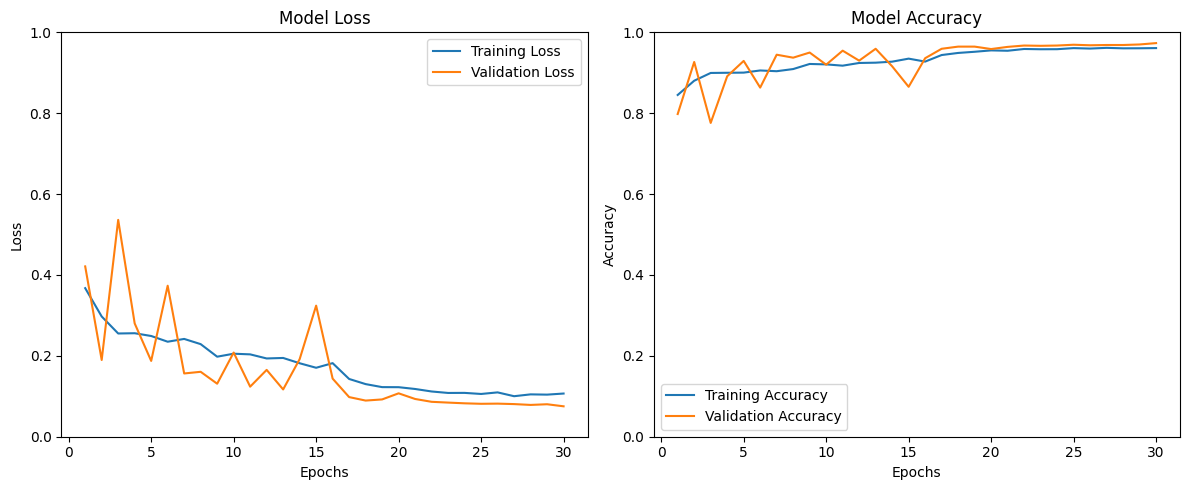

In [ ]:
epochs_ran = range(1, len(history.history['loss'])+1)

plt.figure(figsize=(12,5))

# -------- Loss Chart --------
plt.subplot(1,2,1)
plt.plot(epochs_ran, history.history['loss'], label='Training Loss')
plt.plot(epochs_ran, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim((0,1))

# -------- Accuracy Chart --------
plt.subplot(1,2,2)
plt.plot(epochs_ran, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_ran, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim((0,1))

plt.tight_layout()
plt.show()
